In [1]:
%load_ext autoreload
%autoreload 2
import sys
import pickle
from pathlib import Path
gpu_implementation_path = '/home/mt/repos/research.mtne/gpu_implementation'
if gpu_implementation_path not in sys.path:
    sys.path.append(gpu_implementation_path)
gpu_implementation_analysis_path = '/home/mt/repos/research.mtne/gpu_implementation/analysis'
if gpu_implementation_analysis_path not in sys.path:
    sys.path.append(gpu_implementation_analysis_path)
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import utils
from metrics import *

# from esmt import TrainingState

main_log_dir = Path(gpu_implementation_path) / "logs"

In [2]:
experiments = {
    'ST-zaxxon': {'dir': main_log_dir / 'ST-zaxxon-5000', 'type': 'ST'},
    'ST-riverraid': {'dir': main_log_dir / 'ST-riverraid-5000', 'type': 'ST'},
    'MT': {'dir': main_log_dir / 'MT-zaxxon-riverraid-5000', 'type': 'MT'},
    'MT50k': {'dir': main_log_dir / 'MT-zaxxon-riverraid-50000', 'type': 'MT'},
    'ST-riverraid-zaxxon': {'dir': main_log_dir / 'evaluate_riverraid_using_zaxxon_model', 'type': 'ST'},
    'ST-zaxxon-riverraid': {'dir': main_log_dir / 'evaluate_zaxxon_using_riverraid_model', 'type': 'ST'}    
}

In [3]:
for exp_name, exp in experiments.items():
    exp['cfg'] = utils.get_config(exp)
    exp['rewards'] = utils.get_rewards(exp)
e = experiments

/home/dis/deep-neuroevolution/env/lib/python3.5/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [4]:
e['MT']['cfg']['iterations'] = 200

In [5]:
e['MT50k']['cfg']

{'episode_cutoff_mode': 50000,
 'games': ['zaxxon', 'riverraid'],
 'iterations': 800,
 'l2coeff': 0.005,
 'learn_option': 'concat_rewards',
 'learn_options': ['concat_rewards',
  'alternate_games',
  'equal_prob_random_choice'],
 'model': 'ModelVirtualBN',
 'mutation_power': 0.02,
 'num_test_episodes': 400,
 'num_validation_episodes': 30,
 'optimizer': {'args': {'stepsize': 0.01}, 'type': 'adam'},
 'population_size': 10000,
 'population_size_comment': 'Must be divisible by 4',
 'return_proc_mode': 'centered_rank',
 'timesteps': 5000000000.0}

In [6]:
e['MT50k']['rewards'].head()

,MT-zaxxon_rewards,MT-zaxxon_elite,MT-riverraid_rewards,MT-riverraid_elite
iteration,,,,
0,0.0,52.840000,856.299988,708.145996
1,426.0,31.340000,810.599976,1049.264038
2,983.0,236.139999,1706.500000,1171.923950
3,0.0,292.359985,1971.550049,1703.322021
4,0.0,387.299988,2202.449951,1776.663940


In [7]:
iterations = 200

In [8]:
### https://arxiv.org/pdf/1703.03864.pdf
game0_threshold = 6380 # openai paper ES
game1_threshold = 5009 # openai paper ES

threshold_results = []
for i in range(0, e['MT']['cfg']['iterations']):
    g0r = utils.get_iter_log(e['MT']['dir'], i, 'game0_rewards')
    g1r = utils.get_iter_log(e['MT']['dir'], i, 'game1_rewards')
    g0r_flat = [item for sublist in g0r for item in sublist]
    g1r_flat = [item for sublist in g1r for item in sublist]
    
    for reward_index in range(0, len(g0r_flat)):
        reward_0 = g0r_flat[reward_index]
        reward_1 = g1r_flat[reward_index]
        if reward_0 > game0_threshold and reward_1 > game1_threshold:
            threshold_results.append({'iteration': i, 'offspring_index': reward_index, 'zaxxon': reward_0, 'riverraid': reward_1})
exceeded_threshold = pd.DataFrame(threshold_results)
df_zeros = pd.DataFrame([{'breached': 0} for i in range(0, e['MT']['cfg']['iterations'])])
df_breached = exceeded_threshold.groupby('iteration').count()
df_breached = df_breached[['offspring_index']]
df = pd.merge(df_zeros, df_breached, how='left', left_index=True, right_index=True)
df_breached = pd.DataFrame({'threshold_breached': (df['offspring_index'] / (e['MT']['cfg']['population_size']/2) * 100)})
df = df_breached.fillna(0)
df['iteration'] = df.index

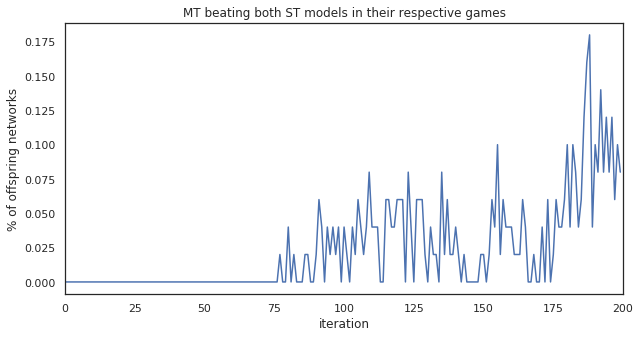

In [9]:
sns.set(rc={'figure.figsize': (10, 5)})
sns.set_style('white')
p = sns.lineplot(x='iteration', y='threshold_breached', data=df)
p.set_title('MT beating both ST models in their respective games')
p.set_xlim([0, e['MT']['cfg']['iterations']])
p.set_ylabel('% of offspring networks')
p.get_figure().savefig("figures/mt_beating_sts.eps")

In [10]:
### https://arxiv.org/pdf/1703.03864.pdf
game0_threshold = 6380 # openai paper ES
game1_threshold = 5009 # openai paper ES

threshold_results = []
for i in range(0, e['MT50k']['cfg']['iterations']):
    g0r = utils.get_iter_log(e['MT50k']['dir'], i, 'game0_rewards')
    g1r = utils.get_iter_log(e['MT50k']['dir'], i, 'game1_rewards')
    g0r_flat = [item for sublist in g0r for item in sublist]
    g1r_flat = [item for sublist in g1r for item in sublist]
    
    for reward_index in range(0, len(g0r_flat)):
        reward_0 = g0r_flat[reward_index]
        reward_1 = g1r_flat[reward_index]
        if reward_0 > game0_threshold and reward_1 > game1_threshold:
            threshold_results.append({'iteration': i, 'offspring_index': reward_index, 'zaxxon': reward_0, 'riverraid': reward_1})
exceeded_threshold = pd.DataFrame(threshold_results)
df_zeros = pd.DataFrame([{'breached': 0} for i in range(0, e['MT50k']['cfg']['iterations'])])
df_breached = exceeded_threshold.groupby('iteration').count()
df_breached = df_breached[['offspring_index']]
df = pd.merge(df_zeros, df_breached, how='left', left_index=True, right_index=True)
df_breached = pd.DataFrame({'threshold_breached': (df['offspring_index'] / (e['MT50k']['cfg']['population_size']/2) * 100)})
df = df_breached.fillna(0)
df['iteration'] = df.index

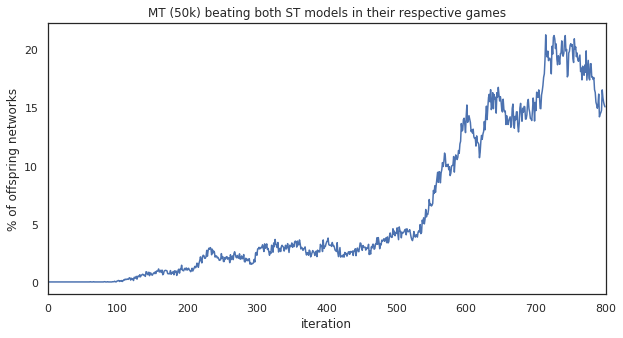

In [11]:
sns.set(rc={'figure.figsize': (10, 5)})
sns.set_style('white')
p = sns.lineplot(x='iteration', y='threshold_breached', data=df)
p.set_title('MT (50k) beating both ST models in their respective games')
p.set_xlim([0, e['MT50k']['cfg']['iterations']])
p.set_ylabel('% of offspring networks')
p.get_figure().savefig("figures/mt50k_beating_sts.eps")

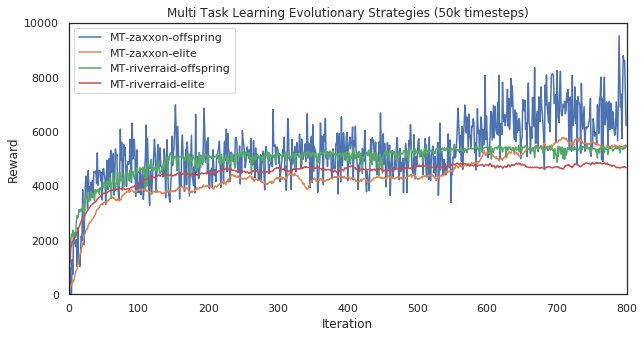

In [12]:
### 50k
# 1) MTES rewards (both offspring and elite)
# x axis: iterations (0 to 200)
# y axis: rewards
# lines: (a) riverraid, offspring; (b) riverraid, elite; (c) zaxxon, offspring; (d) zaxxon, elite.
df = e['MT50k']['rewards'].copy()
df.columns = ['MT-zaxxon-offspring', 'MT-zaxxon-elite', 'MT-riverraid-offspring', 'MT-riverraid-elite']
# df['Iteration'] = df.index
# melted = pd.melt(df, id_vars=['Iteration'])

### BLACK AND WHITE PLOT
# sns.set(rc={'figure.figsize': (10, 5)})
# sns.set_style('white')
# p = sns.lineplot(x='Iteration', y='value', style='variable', color='black', data=melted)
# p.set_title('Multi Task Evolutionary Strategies; TODO: explain rewards and elite')
# p.set_ylabel('Reward')
# p.set(xlim=(0, iterations))
# p.get_figure().savefig("plot1.eps")

### presentation plot
sns.set(rc={'figure.figsize': (10, 5)})
sns.set_style('white')
p = df.plot()
# p = sns.lineplot(x='Iteration', y='value', hue='variable', data=melted)
p.set_title('Multi Task Learning Evolutionary Strategies (50k timesteps)')
p.set_ylabel('Reward')
p.set_xlabel('Iteration')
p.set(ylim=(0, 10000))
p.set(xlim=(0, 800))
p.get_figure().savefig("figures/plot1-50k.eps")

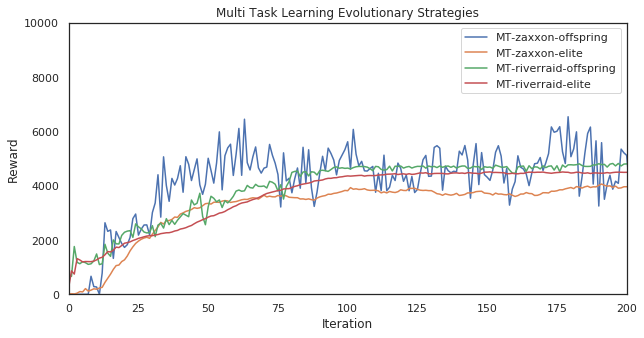

In [13]:
# 1) MTES rewards (both offspring and elite)
# x axis: iterations (0 to 200)
# y axis: rewards
# lines: (a) riverraid, offspring; (b) riverraid, elite; (c) zaxxon, offspring; (d) zaxxon, elite.
df = e['MT']['rewards'].copy()
df.columns = ['MT-zaxxon-offspring', 'MT-zaxxon-elite', 'MT-riverraid-offspring', 'MT-riverraid-elite']
# df['Iteration'] = df.index
# melted = pd.melt(df, id_vars=['Iteration'])

### BLACK AND WHITE PLOT
# sns.set(rc={'figure.figsize': (10, 5)})
# sns.set_style('white')
# p = sns.lineplot(x='Iteration', y='value', style='variable', color='black', data=melted)
# p.set_title('Multi Task Evolutionary Strategies; TODO: explain rewards and elite')
# p.set_ylabel('Reward')
# p.set(xlim=(0, iterations))
# p.get_figure().savefig("plot1.eps")

### presentation plot
sns.set(rc={'figure.figsize': (10, 5)})
sns.set_style('white')
p = df.plot()
# p = sns.lineplot(x='Iteration', y='value', hue='variable', data=melted)
p.set_title('Multi Task Learning Evolutionary Strategies')
p.set_ylabel('Reward')
p.set_xlabel('Iteration')
p.set(ylim=(0, 10000))
p.set(xlim=(0, iterations))
p.get_figure().savefig("figures/plot1.eps")

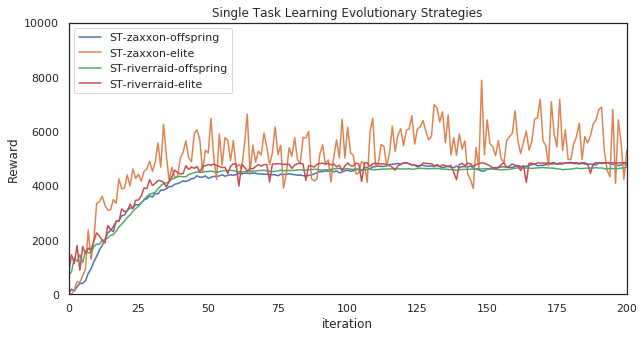

In [14]:
# 1.1) MTES rewards (both offspring and elite)
# x axis: iterations (0 to 200)
# y axis: rewards
# lines: (a) riverraid, offspring; (b) riverraid, elite; (c) zaxxon, offspring; (d) zaxxon, elite.
df_zaxxon = e['ST-zaxxon']['rewards'].copy()
df_zaxxon.columns = ['ST-zaxxon-offspring', 'ST-zaxxon-elite']
df_riverraid = e['ST-riverraid']['rewards'].copy()
df_riverraid.columns = ['ST-riverraid-offspring', 'ST-riverraid-elite']
df = df_zaxxon.join(df_riverraid)
# melted = pd.melt(df, id_vars=['Iteration'])

# ### BLACK AND WHITE PLOT
# # sns.set(rc={'figure.figsize': (10, 5)})
# # sns.set_style('white')
# # p = sns.lineplot(x='Iteration', y='value', style='variable', color='black', data=melted)
# # p.set_title('Multi Task Evolutionary Strategies; TODO: explain rewards and elite')
# # p.set_ylabel('Reward')
# # p.set(xlim=(0, iterations))
# # p.get_figure().savefig("plot1.eps")

# ### presentation plot
# sns.set(rc={'figure.figsize': (10, 5)})
# sns.set_style('white')
p = df.plot()
p.set_title('Single Task Learning Evolutionary Strategies')
p.set_ylabel('Reward')
p.set(ylim=(0, 10000))
p.set(xlim=(0, iterations))
p.get_figure().savefig("figures/plot1_1.eps")

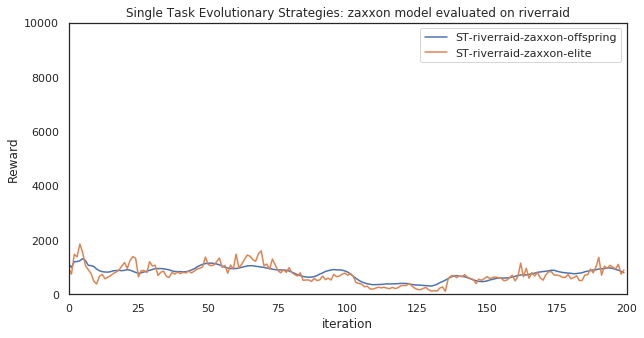

In [15]:
# 1.1) MTES rewards (both offspring and elite)
# x axis: iterations (0 to 200)
# y axis: rewards
# lines: (a) riverraid, offspring; (b) riverraid, elite; (c) zaxxon, offspring; (d) zaxxon, elite.
df = e['ST-riverraid-zaxxon']['rewards'].copy()
df.columns = ['ST-riverraid-zaxxon-offspring', 'ST-riverraid-zaxxon-elite']
# sns.set(rc={'figure.figsize': (10, 5)})
# sns.set_style('white')
p = df.plot()
p.set_title('Single Task Evolutionary Strategies: zaxxon model evaluated on riverraid')
p.set_ylabel('Reward')
p.set(ylim=(0, 10000))
p.set(xlim=(0, iterations))
p.get_figure().savefig("figures/plot2_1.eps")

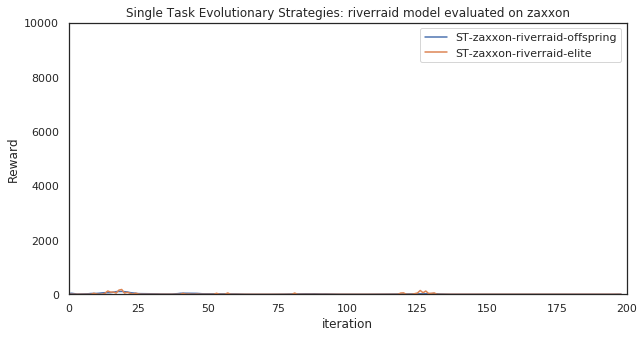

In [16]:
# 1.1) MTES rewards (both offspring and elite)
# x axis: iterations (0 to 200)
# y axis: rewards
# lines: (a) riverraid, offspring; (b) riverraid, elite; (c) zaxxon, offspring; (d) zaxxon, elite.
df = e['ST-zaxxon-riverraid']['rewards'].copy()
df.columns = ['ST-zaxxon-riverraid-offspring', 'ST-zaxxon-riverraid-elite']
# sns.set(rc={'figure.figsize': (10, 5)})
# sns.set_style('white')
p = df.plot()
p.set_title('Single Task Evolutionary Strategies: riverraid model evaluated on zaxxon')
p.set_ylabel('Reward')
p.set(ylim=(0, 10000))
p.set(xlim=(0, iterations))
p.get_figure().savefig("figures/plot2_2.eps")

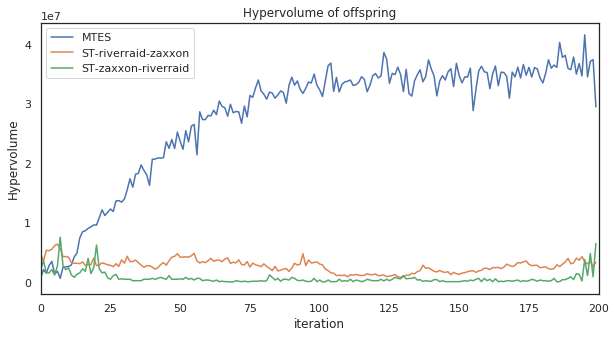

In [18]:
# 4) hypervolume (offspring only)
# x axis: iterations (0 to 200)
# y axis: hypervolume
# lines: (a) MTES
hv_df = pd.DataFrame.from_dict({
    'MTES': utils.get_hypervolume_data(experiments['MT'], iterations)['hv'],
    'ST-zaxxon-riverraid': utils.get_hypervolume_data(experiments['ST-zaxxon-riverraid'], iterations)['hv'],
    'ST-riverraid-zaxxon': utils.get_hypervolume_data(experiments['ST-riverraid-zaxxon'], iterations)['hv'],
})
sns.set(rc={'figure.figsize': (10, 5)})
hv_df['iteration'] = range(0, iterations)
hv_df.set_index('iteration')
del hv_df['iteration']
sns.set_style('white')
p = hv_df.plot()
# p = hv_df.plot(color='black')
p.set_title('Hypervolume of offspring')
p.set_ylabel('Hypervolume')
p.set_xlim([0, 200])
p.get_figure().savefig("figures/plot4_hypervolume.eps")

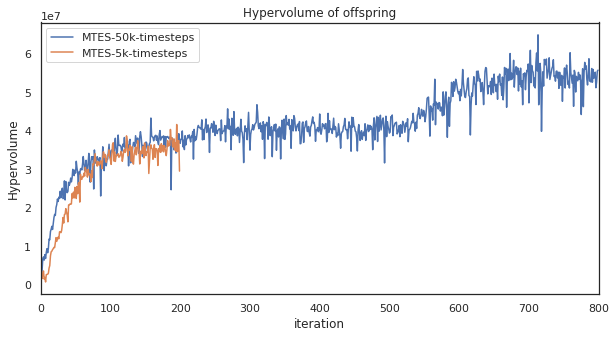

In [29]:
# 4) -- 50k -- hypervolume (offspring only)
hv_50k = utils.get_hypervolume_data(experiments['MT50k'], e['MT50k']['cfg']['iterations'])['hv']
hv_5k = utils.get_hypervolume_data(experiments['MT'], e['MT']['cfg']['iterations'])['hv']
hv_df = pd.merge(pd.DataFrame({'MTES-50k-timesteps': hv_50k}), pd.DataFrame({'MTES-5k-timesteps': hv_5k}), how='left', left_index=True, right_index=True)# sns.set(rc={'figure.figsize': (10, 5)})
hv_df['iteration'] = range(0, e['MT50k']['cfg']['iterations'])
hv_df.set_index('iteration')
del hv_df['iteration']
sns.set_style('white')
p = hv_df.plot()
# p = hv_df.plot(color='black')
p.set_title('Hypervolume of offspring')
p.set_ylabel('Hypervolume')
p.set_xlim([0, e['MT50k']['cfg']['iterations']])
p.get_figure().savefig("figures/plot4_hypervolume-50k.eps")

/home/dis/deep-neuroevolution/env/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/dis/deep-neuroevolution/env/lib/python3.5/site-packages/ipykernel_launcher.py:24: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


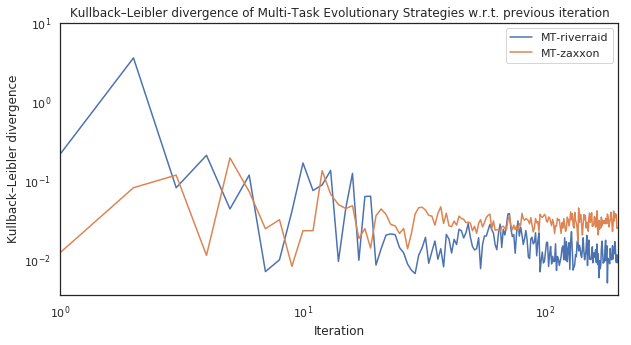

In [30]:
# 5) DKL (offspring only) – 2 plots: one for task 0, one for task 1
# x axis: iterations (0 to 200)
# y axis: DKL for consecutive iterations (1 vs 0, 2 vs 1, 3 vs 2, ... , 200 vs 199)
# lines: (a) MTES; (b) STES [zaxxon evaluated on riverraid]; (c) STES [riverraid evaluated on zaxxon].

bin_size = 100
epsilon = 0.0001
dkl0 = pd.DataFrame.from_dict({
    'MT-zaxxon': [utils.compute_dkl(experiments['MT'], 0, i, bin_size, epsilon, iteration_lag=1) for i in range(1, iterations)],
    'MT-riverraid': [utils.compute_dkl(experiments['MT'], 1, i, bin_size, epsilon, iteration_lag=1) for i in range(1, iterations)]
})

df = dkl0.copy()
# df['iteration'] = df.index
# melted = pd.melt(df, id_vars=['iteration'])
# p = sns.lineplot(x='iteration', y='value', style='variable', color='black', data=melted)
p = df.plot()
p.set_title("Kullback–Leibler divergence of Multi-Task Evolutionary Strategies w.r.t. previous iteration")
p.set_xlabel("Iteration")
p.set_ylabel("Kullback–Leibler divergence")
p.set_yscale('log')
p.set_xscale('log')
p.set_xlim([0, 200])
p.set_ylim([0, 10])
p.get_figure().savefig("figures/plot5_dkl.eps")

/home/dis/deep-neuroevolution/env/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/dis/deep-neuroevolution/env/lib/python3.5/site-packages/ipykernel_launcher.py:19: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


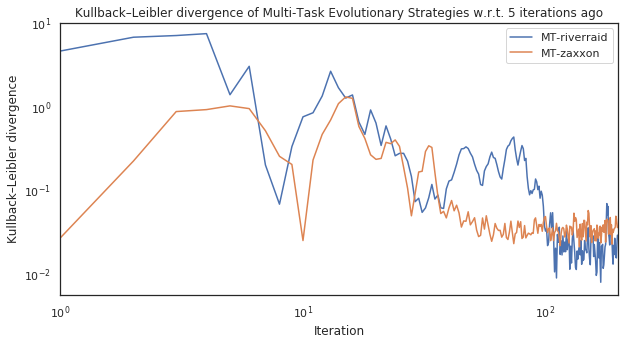

In [31]:
# same as 5) iteration_lag=5
dkl_from0_0 = pd.DataFrame.from_dict({
    'MTES_zaxxon': [utils.compute_dkl(experiments['MT'], 0, i, bin_size, epsilon, iteration_lag=5) for i in range(1, iterations)],
    'MTES_riverraid': [utils.compute_dkl(experiments['MT'], 1, i, bin_size, epsilon, iteration_lag=5) for i in range(1, iterations)]
})

df = dkl_from0_0.copy()
df.columns = ['MT-riverraid', 'MT-zaxxon']
# df['iteration'] = df.index
# melted = pd.melt(df, id_vars=['iteration'])
# p = sns.lineplot(x='iteration', y='value', style='variable', color='black', data=melted)
p = df.plot()
p.set_title("Kullback–Leibler divergence of Multi-Task Evolutionary Strategies w.r.t. 5 iterations ago")
p.set_xlabel("Iteration")
p.set_ylabel("Kullback–Leibler divergence")
p.set_yscale('log')
p.set_xscale('log')
p.set_xlim([0, 200])
p.set_ylim([0, 10])
p.get_figure().savefig("figures/plot6_dkl_mtes-5.eps")

/home/dis/deep-neuroevolution/env/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/dis/deep-neuroevolution/env/lib/python3.5/site-packages/ipykernel_launcher.py:19: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


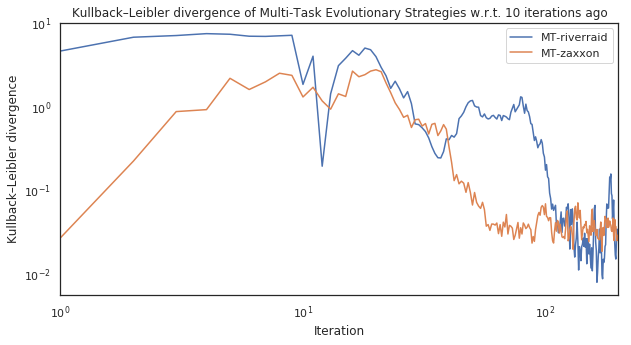

In [32]:
# same as 5) iteration_lag=10
dkl_from0_0 = pd.DataFrame.from_dict({
    'MTES_zaxxon': [utils.compute_dkl(experiments['MT'], 0, i, bin_size, epsilon, iteration_lag=10) for i in range(1, iterations)],
    'MTES_riverraid': [utils.compute_dkl(experiments['MT'], 1, i, bin_size, epsilon, iteration_lag=10) for i in range(1, iterations)]
})

df = dkl_from0_0.copy()
df.columns = ['MT-riverraid', 'MT-zaxxon']
# df['iteration'] = df.index
# melted = pd.melt(df, id_vars=['iteration'])
# p = sns.lineplot(x='iteration', y='value', style='variable', color='black', data=melted)
p = df.plot()
p.set_title("Kullback–Leibler divergence of Multi-Task Evolutionary Strategies w.r.t. 10 iterations ago")
p.set_xlabel("Iteration")
p.set_ylabel("Kullback–Leibler divergence")
p.set_yscale('log')
p.set_xscale('log')
p.set_xlim([0, 200])
p.set_ylim([0, 10])
p.get_figure().savefig("figures/plot6_dkl_mtes-10.eps")

In [ ]:
# same as 5) iteration_lag=20
dkl_from0_0 = pd.DataFrame.from_dict({
    'MTES_zaxxon': [utils.compute_dkl(experiments['MT'], 0, i, bin_size, epsilon, iteration_lag=20) for i in range(1, iterations)],
    'MTES_riverraid': [utils.compute_dkl(experiments['MT'], 1, i, bin_size, epsilon, iteration_lag=20) for i in range(1, iterations)]
})

df = dkl_from0_0.copy()
df.columns = ['MT-riverraid', 'MT-zaxxon']
# df['iteration'] = df.index
# melted = pd.melt(df, id_vars=['iteration'])
# p = sns.lineplot(x='iteration', y='value', style='variable', color='black', data=melted)
p = df.plot()
p.set_title("Kullback–Leibler divergence of Multi-Task Evolutionary Strategies w.r.t. 20 iterations ago")
p.set_xlabel("Iteration")
p.set_ylabel("Kullback–Leibler divergence")
p.set_yscale('log')
p.set_xscale('log')
p.set_xlim([0, 200])
p.set_ylim([0, 10])
p.get_figure().savefig("figures/plot6_dkl_mtes-20.eps")

In [ ]:
# same as 5) iteration_lag=50
dkl_from0_0 = pd.DataFrame.from_dict({
    'MTES_zaxxon': [utils.compute_dkl(experiments['MT'], 0, i, bin_size, epsilon, iteration_lag=50) for i in range(1, iterations)],
    'MTES_riverraid': [utils.compute_dkl(experiments['MT'], 1, i, bin_size, epsilon, iteration_lag=50) for i in range(1, iterations)]
})

df = dkl_from0_0.copy()
df.columns = ['MT-riverraid', 'MT-zaxxon']
# df['iteration'] = df.index
# melted = pd.melt(df, id_vars=['iteration'])
# p = sns.lineplot(x='iteration', y='value', style='variable', color='black', data=melted)
p = df.plot()
p.set_title("Kullback–Leibler divergence of Multi-Task Evolutionary Strategies w.r.t. 50 iterations ago")
p.set_xlabel("Iteration")
p.set_ylabel("Kullback–Leibler divergence")
p.set_yscale('log')
p.set_xscale('log')
p.set_xlim([0, 200])
p.set_ylim([0, 10])
p.get_figure().savefig("figures/plot6_dkl_mtes-50.eps")

In [ ]:
# 6) same as 5), but y axis is “DKL for iterations (1 vs 0, 2 vs 0, 3 vs 0, ... , 200 vs 0)” (note: also in this case we need 2 plots: one for task 0, one for tasak 1)
dkl_from0_0 = pd.DataFrame.from_dict({
    'MTES_zaxxon': [utils.compute_dkl(experiments['MT'], 0, i, bin_size, epsilon, iteration_lag=i) for i in range(1, iterations)],
    'MTES_riverraid': [utils.compute_dkl(experiments['MT'], 1, i, bin_size, epsilon, iteration_lag=i) for i in range(1, iterations)]
})

df = dkl_from0_0.copy()
df.columns = ['MT-riverraid', 'MT-zaxxon']
# df['iteration'] = df.index
# melted = pd.melt(df, id_vars=['iteration'])
# p = sns.lineplot(x='iteration', y='value', style='variable', color='black', data=melted)
p = df.plot()
p.set_title("Kullback–Leibler divergence of Multi-Task Evolutionary Strategies w.r.t. initial distribution")
p.set_xlabel("Iteration")
p.set_ylabel("Kullback–Leibler divergence")
p.set_yscale('log')
p.set_xscale('log')
p.set_xlim([0, 200])
p.set_ylim([0, 10])
p.get_figure().savefig("figures/plot6_dkl_mtes.eps")

In [ ]:
### SCATTERPLOTS

In [ ]:
iterlist = list(range(0, 201))

def get_paretos(exp, iterations, rewards=None, iterlist=iterlist):
    game_rewards = utils.get_game_rewards(exp, iterations) if rewards is None else rewards
    paretos = []
    for iteration in range(0, iterations):
        game0_rewards = game_rewards[game_rewards.iteration == iteration]['game0_rewards']
        game1_rewards = game_rewards[game_rewards.iteration == iteration]['game1_rewards']
        pareto_x, pareto_y = utils.compute_pareto(game0_rewards, game1_rewards)
        paretos.append(pd.DataFrame({'iteration': [iteration] * len(pareto_x), 'game0_rewards': pareto_x, 'game1_rewards': pareto_y}))
    paretos_df = pd.concat(paretos)
    only_paretos = paretos_df[paretos_df['iteration'].isin(iterlist)]
    only_paretos['newidx'] = list(range(0, len(only_paretos)))
    only_paretos.set_index('newidx')
    del only_paretos['newidx']
    return only_paretos
def pareto_and_points_for_iteration(game_rewards, paretos, iteration):
    game_rewards_iteration = game_rewards[game_rewards.iteration == iteration]
    paretos_iteration = paretos[paretos.iteration == iteration]
    return game_rewards_iteration, paretos_iteration
def get_scatter_reward_and_pareto(game_rewards, paretos, iteration, plot_title='Experiment', max_x_lim=10000, max_y_lim=10000, xlabel=None, ylabel=None, rewards_colours='grey', paretos_colours='black', swap_games=False):
    game_rewards, paretos = pareto_and_points_for_iteration(game_rewards, paretos, iteration)

    game0_rewards = game_rewards[game_rewards.iteration == iteration]

    xfield = 'game0_rewards'
    yfield = 'game1_rewards'
    if swap_games:
        xfield = 'game1_rewards'
        yfield = 'game0_rewards'
        
    p = sns.scatterplot(x=xfield, y=yfield, color=rewards_colours, alpha=0.05, data=game_rewards)
    p = sns.scatterplot(x=xfield, y=yfield, color=paretos_colours, data=paretos)
    p = sns.lineplot(x=xfield, y=yfield, color=paretos_colours, data=paretos)
    p.set_title(plot_title + " - Iteration {}".format(iteration))
    p.set_xlim([0, max_x_lim])
    p.set_ylim([0, max_y_lim])
    if xlabel is not None:
        p.set_xlabel(xlabel)
    if ylabel is not None:
        p.set_ylabel(ylabel)
    return p
def get_game0vs1_and_pareto_grid(all_game_rewards, only_paretos, iterlist, savefig, xlabel, ylabel):
    iterlist_keys = list(range(1, len(iterlist) + 1))
    iterdict = dict(zip(iterlist_keys, iterlist))
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    columns = 3
    rows = 3
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plot_xlabel = '' if i in [1, 2, 3, 4, 5, 6] else xlabel
        plot_ylabel = '' if i in [2, 3, 5, 6, 8, 9] else ylabel
        get_scatter_reward_and_pareto(all_game_rewards, only_paretos, iterdict[i], xlabel=plot_xlabel, ylabel=plot_ylabel)
    fig.savefig(savefig)
    return fig

In [ ]:
game_rewards_mt = utils.get_game_rewards(experiments['MT'], iterations)

In [ ]:
paretos_mt = get_paretos(exp, iterations, all_game_rewards)

In [ ]:
experiments['ST-riverraid-zaxxon']['dir_competitor'] = experiments['ST-zaxxon']['dir']
agr_st_riverraid_zaxxon = utils.get_game_rewards(experiments['ST-riverraid-zaxxon'], iterations)
only_paretos_st_riverraid_zaxxon = get_paretos(exp, iterations, agr_st_riverraid_zaxxon)

In [ ]:
experiments['ST-zaxxon-riverraid']['dir_competitor'] = experiments['ST-riverraid']['dir']
agr_st_zaxxon_riverraid = utils.get_game_rewards(experiments['ST-zaxxon-riverraid'], iterations)
only_paretos_st_zaxxon_riverraid = get_paretos(exp, iterations, agr_st_zaxxon_riverraid)

In [ ]:
for i in range(1, 201):
    p = get_scatter_reward_and_pareto(agr_st_riverraid_zaxxon, only_paretos_st_riverraid_zaxxon, i, plot_title='ST-zaxxon-riverraid', rewards_colours='blue', paretos_colours='blue', xlabel='zaxxon using riverraid', ylabel='riverraid')
    p.get_figure().savefig('figures/plot_pareto_st_riverraid_zaxxon-{}.png'.format(i))
    p.get_figure().clf()
    
for i in range(1, 201):
    p2 = get_scatter_reward_and_pareto(agr_st_zaxxon_riverraid, only_paretos_st_zaxxon_riverraid, i, plot_title='ST-riverraid-zaxxon', rewards_colours='red', paretos_colours='red', xlabel='zaxxon', ylabel='riverraid using zaxxon model', swap_games=True)
    p2.get_figure().savefig('figures/plot_pareto_st_zaxxon_riverraid-{}.png'.format(i))
    p2.get_figure().clf()
    
for i in range(1, 201):
    p3 = get_scatter_reward_and_pareto(game_rewards_mt, paretos_mt, i, plot_title='MT', rewards_colours='grey', paretos_colours='black', xlabel='zaxxon', ylabel='riverraid')
    p3.get_figure().savefig('figures/plot_pareto_mt-{}.png'.format(i))
    p3.get_figure().clf()

In [ ]:
get_game0vs1_and_pareto_grid(all_game_rewards, only_paretos, iterlist, savefig='scatterplot1.eps', xlabel='zaxxon', ylabel='riverraid')

In [ ]:
# Scatterplots: (one plot for iterations: [0, 25, 50, 75, 100, 125, 150, 175, 200] ) → 9 plots
# 1) MTES (only offspring)
# x axis: Game 0
# y axis: Game 1
# points: (a) feasible points only (reward>0); (b) pareto front points, in red + red line connecting those points.
all_game_rewards = utils.get_game_rewards(experiments['MT'], iterations)
only_paretos = get_paretos(exp, iterations, all_game_rewards)
get_game0vs1_and_pareto_grid(all_game_rewards, only_paretos, iterlist, savefig='scatterplot1.eps', xlabel='zaxxon', ylabel='riverraid')

In [ ]:
# 2) same as (1), but STES [zaxxon evaluated on riverraid] instead of MTES
# here game0 is "riverraid evaluated using zaxxon model" and game1 is ST zaxxon (competitor)
experiments['ST-riverraid-zaxxon']['dir_competitor'] = experiments['ST-zaxxon']['dir']
agr_st_riverraid_zaxxon = utils.get_game_rewards(experiments['ST-riverraid-zaxxon'], iterations)
only_paretos_st_riverraid_zaxxon = get_paretos(exp, iterations, agr_st_riverraid_zaxxon)
p = get_game0vs1_and_pareto_grid(agr_st_riverraid_zaxxon, only_paretos_st_riverraid_zaxxon, iterlist, savefig='scatterplot2.eps', xlabel='riverraid using zaxxon model', ylabel='zaxxon')

In [ ]:
# 3) same as (2) but STES [riverraid evaluated on zaxxon]
# here game0 is "zaxxon evaluated using riverraid model" and game1 is ST riverraid (competitor)
experiments['ST-zaxxon-riverraid']['dir_competitor'] = experiments['ST-riverraid']['dir']
agr_st_zaxxon_riverraid = utils.get_game_rewards(experiments['ST-zaxxon-riverraid'], iterations)
only_paretos_st_zaxxon_riverraid = get_paretos(exp, iterations, agr_st_zaxxon_riverraid)
p = get_game0vs1_and_pareto_grid(agr_st_zaxxon_riverraid, only_paretos_st_zaxxon_riverraid, iterlist, savefig='scatterplot3.eps', xlabel='zaxxon using riverraid model', ylabel='riverraid')

In [ ]:
# 1) MTES (only offspring)
# x axis: Game 0
# y axis: Game 1
# points: pareto front points + line connecting those points. One line for each iterations in [0, 25, 50, 75, 100, 125, 150, 175, 200]
p = sns.lineplot(x='game0_rewards', y='game1_rewards', hue='iteration', color='black', legend='full', data=only_paretos)
p.set_title("Pareto Front evolution in MTES offspring")
p.set_xlabel('zaxxon rewards')
p.set_ylabel('riverraid rewards')
p.get_figure().savefig("paretofront.eps")